# ML: Breast Cancer

1. split data
2. encode train data and test data separately using Target Encoder (y using labelencoder)
3. remove missing values from train data and test data separately using KNN
4. upsample train data using SMOTE
5. No Feature selection used
6. xgboost hypertuned

## Part 0: Pre-requisites 

### Imports

In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
import sklearn
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

### Functions:

In [2]:
'''
    function to plot learning curve
'''
def plot_learning_curves(model, x_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
#################################################################################################
'''
    functions to save model and retrieve model
'''
path = "Models\\"
def saveModel(fileName, model):
  with open(path + fileName, 'wb') as f:
      pickle.dump(model, f)

def getModel(fileName):
  with open(path + fileName, 'rb') as f:
      loaded_model = pickle.load(f)
  return loaded_model

results = [] # Array used to store tuples of (model, accuracy_score)
#################################################################################################
'''
    function to split data
'''
def train_val_test_split(x, y):
    # Splitting into training (80%) and temporary set (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=3)
    # Splitting the temporary set into validation (50%) and test (50%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=3)
    return x_train, y_train, x_val, y_val, x_test, y_test
#################################################################################################
'''
    function to find the distribution of null values in the dataset
'''
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

## Part 1: Data 

### Load the data 

In [3]:
data = pd.read_csv("data.csv", encoding="utf-8")
data.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_15216\3240169054.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="utf-8")


,cancer_type,patient_id,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,474,54.29,High,1,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,7029,43.45,Moderate,0,LumA,4,Positve,Positive,1.0,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,5215,74.11,High,0,LumB,3,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,5412,51.87,High,0,LumA,3,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,465,87.18,Moderate,0,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(data.shape)
print(data[data['cancer_type'] == "Breast Invasive Ductal Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Mixed Ductal and Lobular Carcinoma"].shape[0])
print(data[data['cancer_type'] == "Breast Invasive Mixed Mucinous Carcinoma"].shape[0])

(1496, 688)
1199
114
165
18


↪ Our dataset is imbalanced
- we cannot undersample due to the fact that our dataset is mall
- random oversampling may lead to overfitting
- there are other techniques for oversamplign (**SMOTE**)
- setting class weights in an inversely prop way to its freq.
- **boosting** and **bagging** models, **random forest** model are good options.
- use **f1-score** or any metric that is sensitive to data imbalance.  

##### Split into features (x) and label (y)

In [4]:
# splitting data and dropping unnecessary features
y = data["cancer_type"]
x = data.drop(columns = ["cancer_type","patient_id"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=3)

In [5]:
def data_encoding(x, y):
    ordinal_features = ['cellularity','3-gene_classifier_subtype','death_from_cancer','pam50_+_claudin-low_subtype','her2_status_measured_by_snp6']# should add the genetic mutation cols too
    nominal_features = ['er_status_measured_by_ihc','er_status','her2_status','inferred_menopausal_state','primary_tumor_laterality','pr_status']

    x[ordinal_features] = x[ordinal_features].apply(LabelEncoder().fit_transform)
    x[nominal_features] = x[nominal_features].apply(LabelEncoder().fit_transform)

    genomic_col = x.columns[513:] # genetic mutations
    for col in genomic_col:
        x.loc[x[col] != '0', col] = 1
        x.loc[x[col] == '0', col] = 0
        x[col] = x[col].astype(int)
    
    # encoding labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return x,y

def data_encoding2(x,y):
    def get_categorical_columns(df):
        return list(df.select_dtypes(include=['object', 'category']).columns)
    def get_numerical_columns(df):
        return list(df.select_dtypes(include=['number']).columns)

    categorical_columns = get_categorical_columns(x)
    numerical_columns = get_numerical_columns(x)

    # Clean categorical columns to remove duplicates and unexpected formats
    def clean_categorical_columns(df, cat_columns):
        cleaned_df = df.copy()
        for col in cat_columns:
            cleaned_df[col] = cleaned_df[col].apply(lambda x: str(x).strip())  # Strip leading/trailing spaces
            cleaned_df[col] = cleaned_df[col].apply(lambda x: ' '.join(sorted(set(x.split()))))  # Remove duplicate words
        return cleaned_df

    def clean_target_variable(y):
        cleaned_y = y.copy()
        cleaned_y = cleaned_y.apply(lambda x: str(x).strip())  # Strip leading/trailing spaces
        cleaned_y = cleaned_y.apply(lambda x: ' '.join(sorted(set(x.split()))))  # Remove duplicate words
        return cleaned_y

    x_cleaned = clean_categorical_columns(x, categorical_columns)
    y_cleaned = clean_target_variable(y)

    # Use LabelEncoder for encoding target variable
    label_encoder_y = LabelEncoder()
    y_encoded = label_encoder_y.fit_transform(y_cleaned)

    encoder = ce.TargetEncoder(cols=categorical_columns)
    x_encoded = encoder.fit_transform(x_cleaned, y_encoded)

    return x_encoded, y_encoded

def impute_missing_values_KNN(x):
    imputer = KNNImputer(n_neighbors=2)
    x.iloc[:,:] = imputer.fit_transform(x)
    return x

def data_upsampling(x, y):
    # summarize distribution before upsampling
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()

    oversample = SMOTE()
    x, y = oversample.fit_resample(x, y)
    # summarize distribution after upsampling
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()
    return x,y

def preprocess_data(x,y):
    x,y = data_encoding2(x, y)
    x = impute_missing_values_KNN(x)
    x,y = data_upsampling(x, y)
    return x,y

## Part 3: Models

### XGBOOST:

Class=0, n=1081 (80.312%)
Class=2, n=100 (7.429%)
Class=1, n=149 (11.070%)
Class=3, n=16 (1.189%)


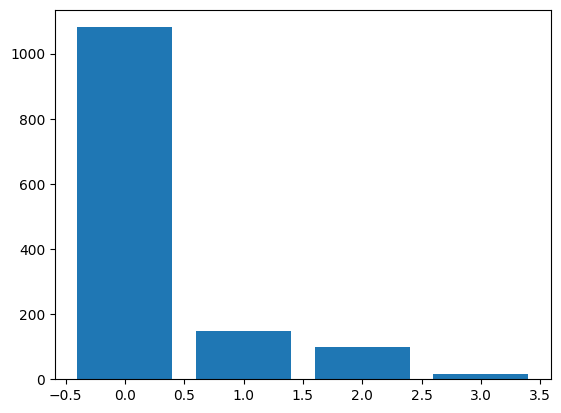

Class=0, n=1081 (25.000%)
Class=2, n=1081 (25.000%)
Class=1, n=1081 (25.000%)
Class=3, n=1081 (25.000%)


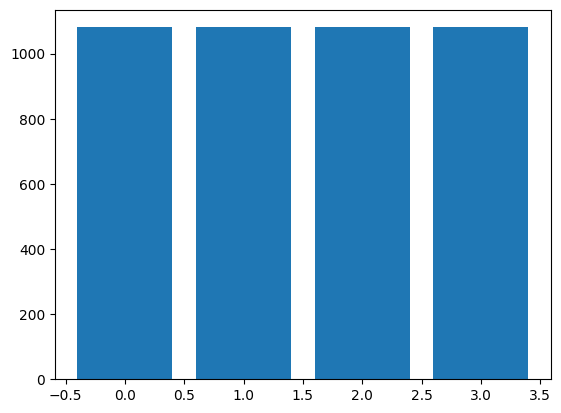

In [6]:
x_train_encoded,y_train_encoded = preprocess_data(x_train,y_train)

x_test_encoded,y_test_encoded = data_encoding2(x_test,y_test)
x_test_encoded = impute_missing_values_KNN(x_test_encoded)

In [7]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    # 'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.5, 1, 1.5],
    'eta': [0.01, 0.1, 0.2],
    # 'lambda': [0.01, 0.1, 1],
    # 'alpha': [0, 0.1, 0.5, 1],
    'max_depth': [3, 6, 9],
}

# Create a model
xgb_model = XGBClassifier(use_label_encoder=False, objective='multi:softprob')
# Create grid search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro',n_jobs=4)
# Fit the grid search object to the train data
grid_search.fit(x_train_encoded, y_train_encoded)

# Best hyperparameters
best_params = grid_search.best_params_
print("best params: ",best_params)

# Cross-validation f1-macro score
best_score = grid_search.best_score_
print("Cross-validation f1-macro score: ", best_score)

# Refit the model with best hyperparameters to the train data
best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, objective='multi:softprob')
best_xgb_model.fit(x_train_encoded, y_train_encoded)

# Predict labels of test data
y_test_pred = best_xgb_model.predict(x_test_encoded)

# Calculate performance metrics on Test Data
accuracy = accuracy_score(y_test_encoded, y_test_pred)
precision = precision_score(y_test_encoded, y_test_pred, average="macro")
recall = recall_score(y_test_encoded, y_test_pred, average="macro")
f1 = f1_score(y_test_encoded, y_test_pred, average="macro")

print("Evaluation on Test data: ")
print("accuracy =", accuracy)
print("precision =", precision)
print("recall =", recall)
print("f1-score =", f1)

# Save the best model
saveModel('best_xgb_model_main_4_2.pkl', best_xgb_model)

best params:  {'eta': 0.2, 'max_depth': 9}
Cross-validation f1-macro score:  0.9830699121215346
Evaluation on Test data: 
accuracy = 0.13333333333333333
precision = 0.2047952047952048
recall = 0.3236607142857143
f1-score = 0.16621743036837378


c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    # 'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.5, 1, 1.5],
    'eta': [0.01, 0.1, 0.2],
    # 'lambda': [0.01, 0.1, 1],
    # 'alpha': [0, 0.1, 0.5, 1],
    'max_depth': [3, 6, 9],
}

# Create a model
xgb_model = XGBClassifier()
# Create grid search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro',n_jobs=4)
# Fit the grid search object to the train data
grid_search.fit(x_train_encoded, y_train_encoded)

# Best hyperparameters
best_params = grid_search.best_params_
print("best params: ",best_params)

# Cross-validation f1-macro score
best_score = grid_search.best_score_
print("Cross-validation f1-macro score: ", best_score)

# Refit the model with best hyperparameters to the train data
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(x_train_encoded, y_train_encoded)

# Predict labels of test data
y_test_pred = best_xgb_model.predict(x_test_encoded)

# Calculate performance metrics on Test Data
accuracy = accuracy_score(y_test_encoded, y_test_pred)
precision = precision_score(y_test_encoded, y_test_pred, average="macro")
recall = recall_score(y_test_encoded, y_test_pred, average="macro")
f1 = f1_score(y_test_encoded, y_test_pred, average="macro")

print("Evaluation on Test data: ")
print("accuracy =", accuracy)
print("precision =", precision)
print("recall =", recall)
print("f1-score =", f1)

# Save the best model
saveModel('best_xgb_model_main_4_3.pkl', best_xgb_model)

best params:  {'eta': 0.2, 'max_depth': 9}
Cross-validation f1-macro score:  0.9830699121215346
Evaluation on Test data: 
accuracy = 0.13333333333333333
precision = 0.2047952047952048
recall = 0.3236607142857143
f1-score = 0.16621743036837378


c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
  

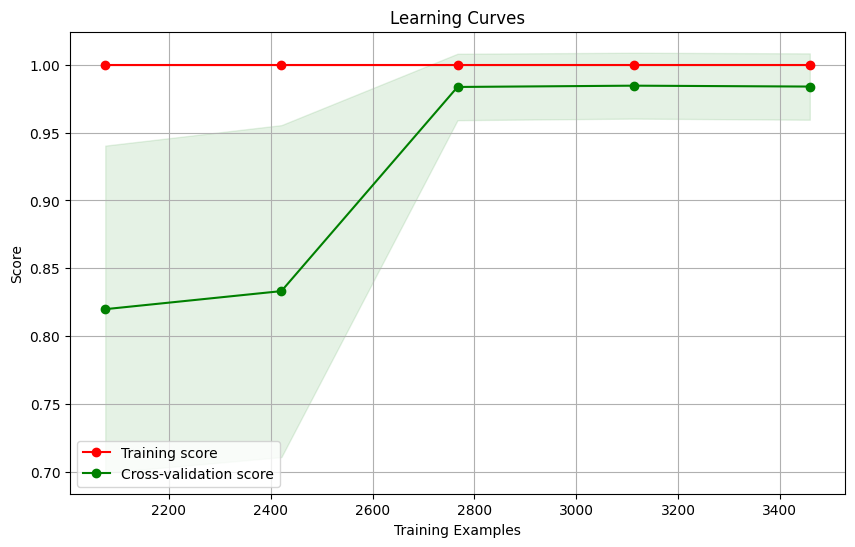

In [13]:
# plot learning curve for the best model
plot_learning_curves(best_xgb_model, x_train_encoded, y_train_encoded)